In [11]:
from matplotlib.widgets import RectangleSelector # Don't use matplotlib==3.3.2
import numpy as np
import matplotlib.pyplot as plt
import os, shutil, uuid, time
import aitom.io.file as io_file
import ipywidgets as ipyw
from ipywidgets import HBox, VBox, Label, widgets, Button, Layout, interact
from aitom.filter.gaussian import smooth
from skimage.transform import rescale
import csv

In [2]:
## Annotation box on 2D image
%matplotlib notebook

def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['M', 'm'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)


In [3]:
class ImageSliceViewer3D:
    def __init__(self, path, rescale_size = 0.2, figsize=(6,6), cmap='gray'): 
        # rescale image
        vol = io_file.read_mrc_data(path)  
        self.rescale_size = rescale_size
        self.volume = rescale(vol, self.rescale_size, anti_aliasing=False)
        self.figsize = figsize
        self.cmap = cmap
        self.v = [np.min(self.volume), np.max(self.volume)]
        self.fig, self.current_ax = plt.subplots()
        self.annotations = {}
        ipyw.interact(self.view_selection)
         
    
    def line_select_callback(self, eclick, erelease):
        'eclick and erelease are the press and release events'
        self.x1, self.y1 = eclick.xdata, eclick.ydata
        self.x2, self.y2 = erelease.xdata, erelease.ydata
    

        
    def plot_slice(self, z, z_lower, z_upper, NewBox, FinishCurrentBox, label, sigma=2, R=10):
        time1 = time.time()
        a = self.volume
        
        # Smooth
        if sigma == 0:
            a_smooth = a
        else:
            a_smooth = smooth(a,sigma)
        
        # Get image
        img = a_smooth[:,:,z]
        plt.rcParams['figure.figsize'] = self.figsize
        self.current_ax.imshow(img, cmap = self.cmap)
        
        # Change box color based on lower and upper bound of z
        box_c = 'green'
        if z <= z_lower or z >= z_upper:
            box_c = 'red'
        
        # Store label and bounding box info when done with the current box
        if FinishCurrentBox:
            coordinates = toggle_selector.RS.extents  # Return (xmin, xmax, ymin, ymax) 
            coordinates = coordinates*5
            xmin=coordinates[0]
            xmax=coordinates[1]
            ymin=coordinates[2]
            ymax=coordinates[3]
            boxInfo=[xmin,ymin,z_lower,xmax-xmin,ymax-ymin,z_upper-z_lower]
            #boxInfo = [coordinates,z_lower,z_upper]
            self.annotations[label] = boxInfo 
            
            
            
        
        # Adding a new bounding box
        if NewBox:
            toggle_selector.RS = RectangleSelector(self.current_ax, self.line_select_callback,
                                           drawtype='box', useblit=True,
                                           button=[1, 3],  # don't use middle button  
                                           minspanx=5, minspany=5,
                                           spancoords='pixels',
                                           interactive=True,
                                           rectprops = dict(edgecolor = box_c, alpha=1, fill=False))
            plt.connect('key_press_event', toggle_selector)
        
        print('plot_slice time',time.time()-time1)
        
   
        
    def view_selection(self):
        maxZ = self.volume.shape[2] - 1   
        
        style = {'description_width': 'initial'}
        
        # Adjustable variables
        z=ipyw.IntSlider(min=0, max=maxZ, step=1, value=0, descritpion='z', style=style,continuous_update=False)
        sigma=ipyw.FloatSlider(min=0, max=10, step=0.5, value=2.0, continuous_update=False)
        R=ipyw.IntSlider(min=1, max=20, step=3, value=10, continuous_update=False)
        z_lower = ipyw.BoundedIntText(value=0,min=0,max=maxZ,step=1,description='',disabled=False)
        z_upper = ipyw.BoundedIntText(value=0,min=0,max=maxZ,step=1,description='',disabled=False)
        #z_lower=ipyw.IntSlider(min=0, max=maxZ, step=1, value=0, descritpion='z_lower', style=style,continuous_update=False)
        #z_upper=ipyw.IntSlider(min=0, max=maxZ, step=1, value=0, descritpion='z_upper', style=style,continuous_update=False)
        label = ipyw.Text(value='Enter label here', placeholder='Type something', description='', disabled=False)
        NewBox = ipyw.ToggleButton(value=False, description='Click me', disabled=False,
                                        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
                                        tooltip='Start a new box',
                                        icon='check',
                                        layout = Layout(width="30%",height='30px'))
        FinishCurrentBox = ipyw.ToggleButton(value=False, description='Click me', disabled=False,
                                        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
                                        tooltip='Finish the current box',
                                        icon='check',
                                        layout = Layout(width="30%",height='30px'))
        
        
       
        H1 = HBox([HBox([Label('sigma'),sigma]),HBox([Label('R'),R])])
        H2 = HBox([Label('z'),z])
        H3 = HBox([HBox([Label('z_lower'),z_lower]),HBox([Label('z_upper'),z_upper])])
        H4 = HBox([Label('label'),label])
        H5 = HBox([Label('NewBox'), NewBox])
        H6 = HBox([Label('FinishCurrentBox'), FinishCurrentBox])
        ui = VBox([H1,H2,H3,H4,H5,H6])
        
        
        out = widgets.interactive_output(self.plot_slice, 
                                         { 'sigma': sigma, 'R': R, 
                                          'z_lower': z_lower, 'z_upper': z_upper, 
                                          'NewBox': NewBox, 'FinishCurrentBox': FinishCurrentBox,
                                         'label': label,'z': z})   
        
            
        display(ui, out)
    
    
        
        

In [4]:
File_Name = widgets.Text(value='Please choose the file ', placeholder='Type something', description='', disabled=False)
File_Name #display the enter 

Text(value='Please choose the file ', placeholder='Type something')

Steps:
1. Confirm z_lower, z_upper
2. Check NewBox and uncheck it
3. Draw bounding box use mouse and change z to adjust size
4. Enter label for the object
5. Check FinishCurrentBox and uncheck it
6. When finished all bounding boxes, get annotations info

/Users/xuqiantan/anaconda3/envs/aitom/lib/python3.7/site-packages/mrcfile/mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x44 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)


<IPython.core.display.Javascript object>


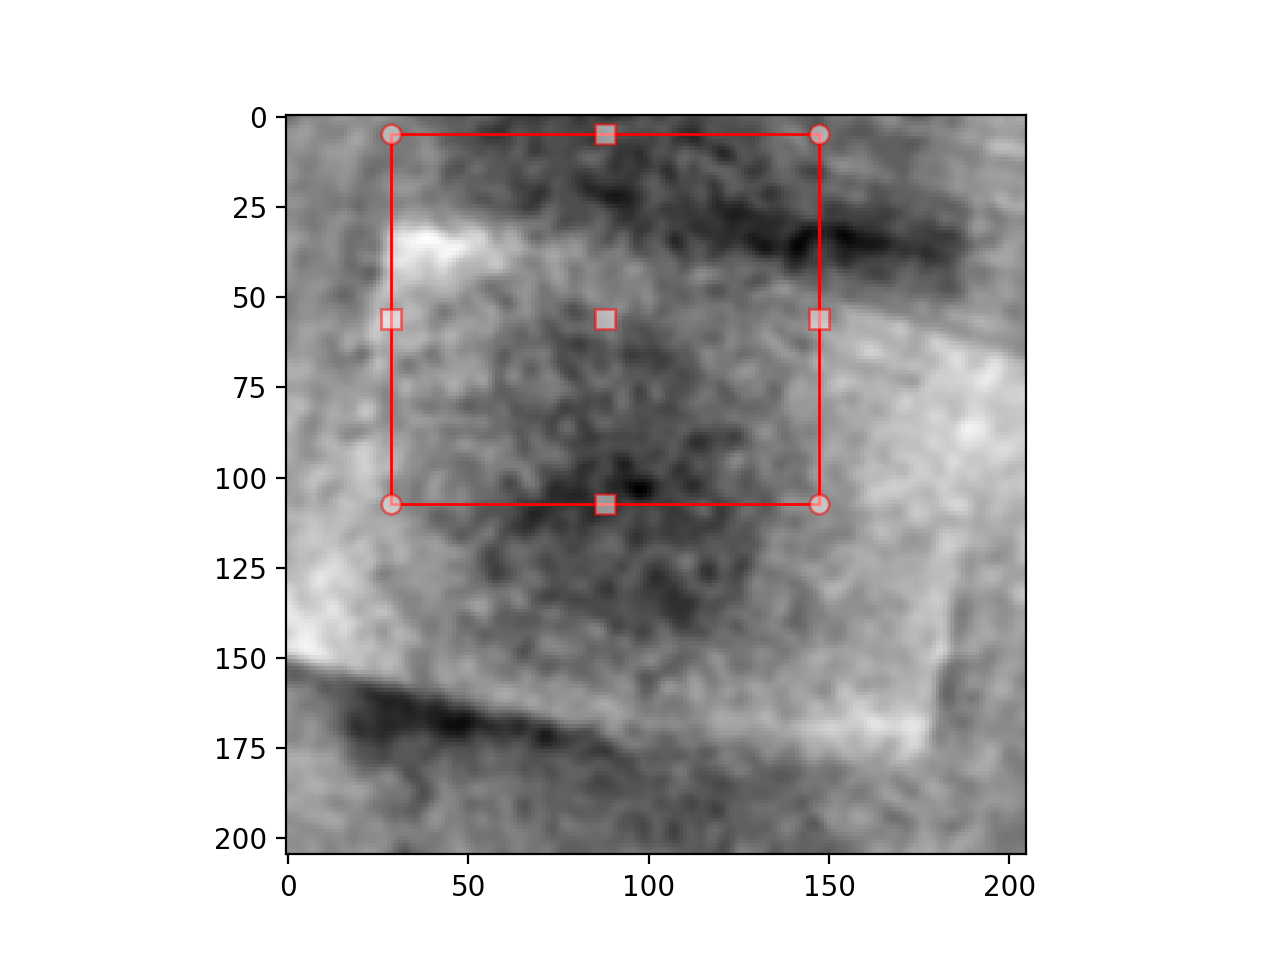

interactive(children=(Output(),), _dom_classes=('widget-interact',))

In [5]:
%matplotlib notebook
#path = 'aitom_demo_cellular_tomogram.mrc'
path = File_Name.value
image_slice_viewer3D = ImageSliceViewer3D(path)

In [13]:
def SaveResult(image_slice_viewer3D):
    # Save resized image
    np.save("./AnnotationResults/resizedImg.npy", image_slice_viewer3D.volume)
    # Save coresponding boundaries 
    with open("./AnnotationResults/AnnotatedBoundary.csv", "w") as csv_file:
        writer = csv.writer(csv_file)
        for key, value in image_slice_viewer3D.annotations.items():
            writer.writerow([key, value])

In [14]:
SaveResult(image_slice_viewer3D)